<a href="https://colab.research.google.com/github/sheetal-kumar/repos/blob/main/Analysis_of_Twitter_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import re
import warnings

#Visualisation
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from IPython.display import display
#from mpl_toolkits.basemap import Basemap
from wordcloud import WordCloud, STOPWORDS

#nltk
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize

#sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

matplotlib.style.use('ggplot')
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore")

%matplotlib inline

#Getting data
tweets = pd.read_csv('tweets_all.csv', encoding = "ISO-8859-1")
display(tweets.head(3))

,Unnamed: 0,text,retweet_count,favorited,truncated,id_str,in_reply_to_screen_name,source,retweeted,created_at,...,place_type,full_name,place_name,place_id,place_lat,place_lon,lat,lon,expanded_url,url
0,7,Good morning. \r\n#njspots #toxictins #njshoot...,0,False,False,806435522684063744,NaN,"<a href=""http://instagram.com"" rel=""nofollow"">...",False,Wed Dec 07 09:49:46 +0000 2016,...,city,"Mercerville, NJ",NaN,NaN,40.227928,-74.703982,40.236494,-74.717857,http://fb.me/1vMVgkYg7,https://t.co/q7R11FO1eU
1,15,@DinaPugliese Good morning Dina :) Have a terr...,0,False,False,806435535132721152,DinaPugliese,"<a href=""http://twitter.com/download/android"" ...",False,Wed Dec 07 09:49:49 +0000 2016,...,city,"Cochrane, Ontario",NaN,NaN,49.145331,-81.073921,NaN,NaN,NaN,NaN
2,18,#good morning everyone. https://t.co/u6W1jI4tKz,0,False,False,806435538928594944,NaN,"<a href=""http://twitter.com/download/android"" ...",False,Wed Dec 07 09:49:49 +0000 2016,...,city,"Lawrence, IN",NaN,NaN,39.870398,-85.996819,NaN,NaN,NaN,NaN


In [ ]:
tweets['text'][1]

'@DinaPugliese Good morning Dina :) Have a terrific hump day! :) Little snowy in Cochrane today. https://t.co/P3j1dtUs6y'

In [ ]:
#Preprocessing del RT @blablabla:
tweets['tweetos'] = '' 

#add tweetos first part
for i in range(len(tweets['text'])):
    try:
        tweets['tweetos'][i] = tweets['text'].str.split(' ')[i][0]
    except AttributeError:    
        tweets['tweetos'][i] = 'other'

#Preprocessing tweetos. select tweetos contains 'RT @'
for i in range(len(tweets['text'])):
    if tweets['tweetos'].str.contains('@')[i]  == False:
        tweets['tweetos'][i] = 'other'
        
# remove URLs, RTs, and twitter handles
for i in range(len(tweets['text'])):
    tweets['text'][i] = " ".join([word for word in tweets['text'][i].split()
                                if 'http' not in word and '@' not in word and '<' not in word])

In [ ]:
tweets['text'][1]

'Good morning Dina :) Have a terrific hump day! :) Little snowy in Cochrane today.'

In [ ]:
tweets['text'] = tweets['text'].apply(lambda x: re.sub('[!@#$:).;,?&]', '', x.lower()))
tweets['text'] = tweets['text'].apply(lambda x: re.sub('  ', ' ', x))

In [ ]:
tweets['text'][1]

'good morning dina have a terrific hump day little snowy in cochrane today'

In [ ]:
def wordcloud(tweets,col):
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(background_color="white",stopwords=stopwords,random_state = 2016).generate(" ".join([i for i in tweets[col]]))
    plt.figure( figsize=(20,10), facecolor='k')
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title("Good Morning Datascience+")

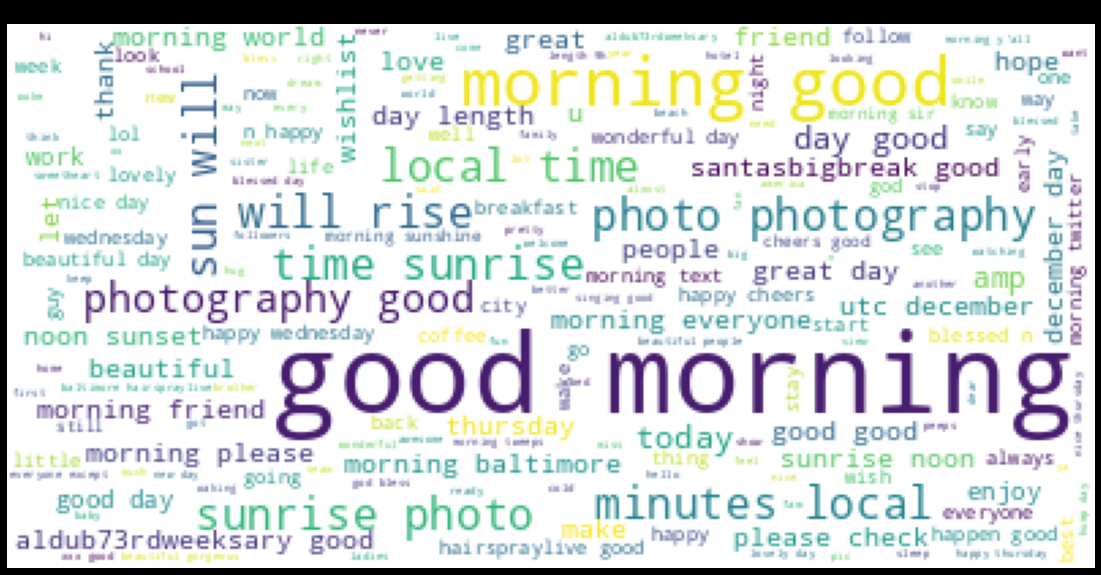

In [ ]:
wordcloud(tweets,'text')  

In [ ]:
tweets['source'][2]

'<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>'

In [ ]:
tweets['source_new'] = ''

for i in range(len(tweets['source'])):
    m = re.search('(?<=>)(.*)', tweets['source'][i])
    try:
        tweets['source_new'][i]=m.group(0)
    except AttributeError:
        tweets['source_new'][i]=tweets['source'][i]
        
tweets['source_new'] = tweets['source_new'].str.replace('</a>', ' ', case=False)

In [ ]:
tweets['source_new'].head()

0              Instagram 
1    Twitter for Android 
2    Twitter for Android 
3    Twitter for Android 
4     Twitter Web Client 
Name: source_new, dtype: object

<Axes: title={'center': 'Number of followers by Source'}, xlabel='source_new'>

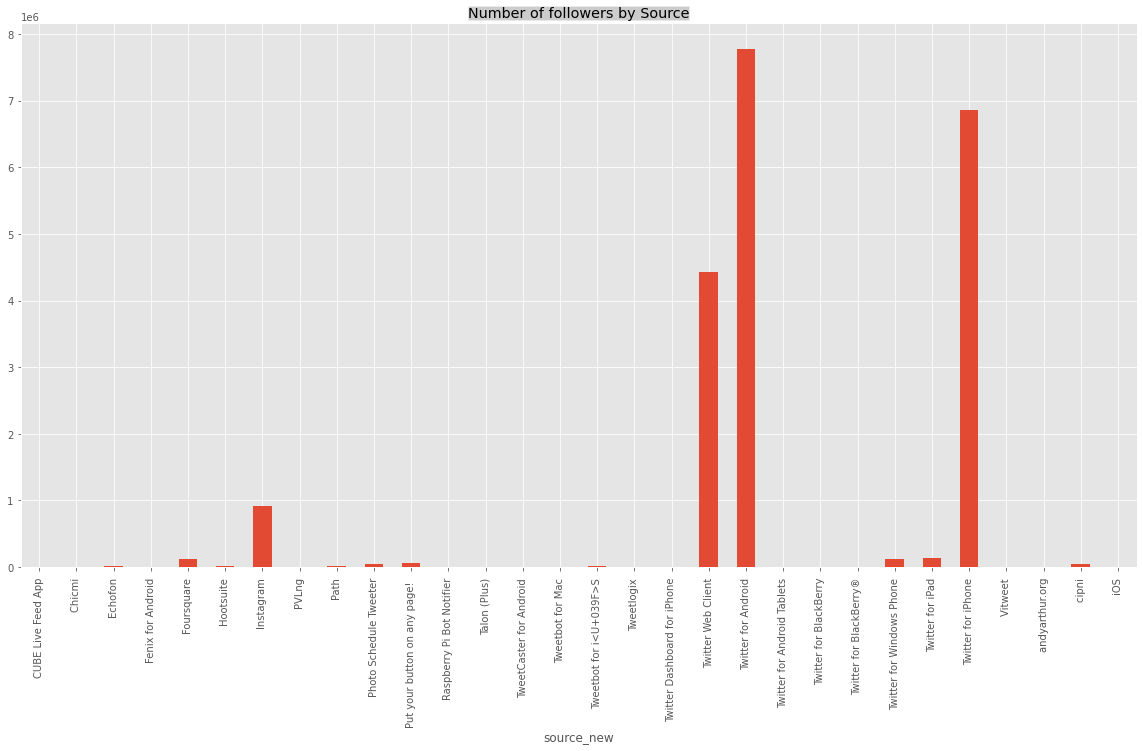

In [ ]:
tweets_by_type = tweets.groupby(['source_new'])['followers_count'].sum()
plt.title('Number of followers by Source', bbox={'facecolor':'0.8', 'pad':0})
tweets_by_type.transpose().plot(kind='bar',figsize=(20, 10))

Text(0.5, 1.0, 'Number of followers by Source bis')

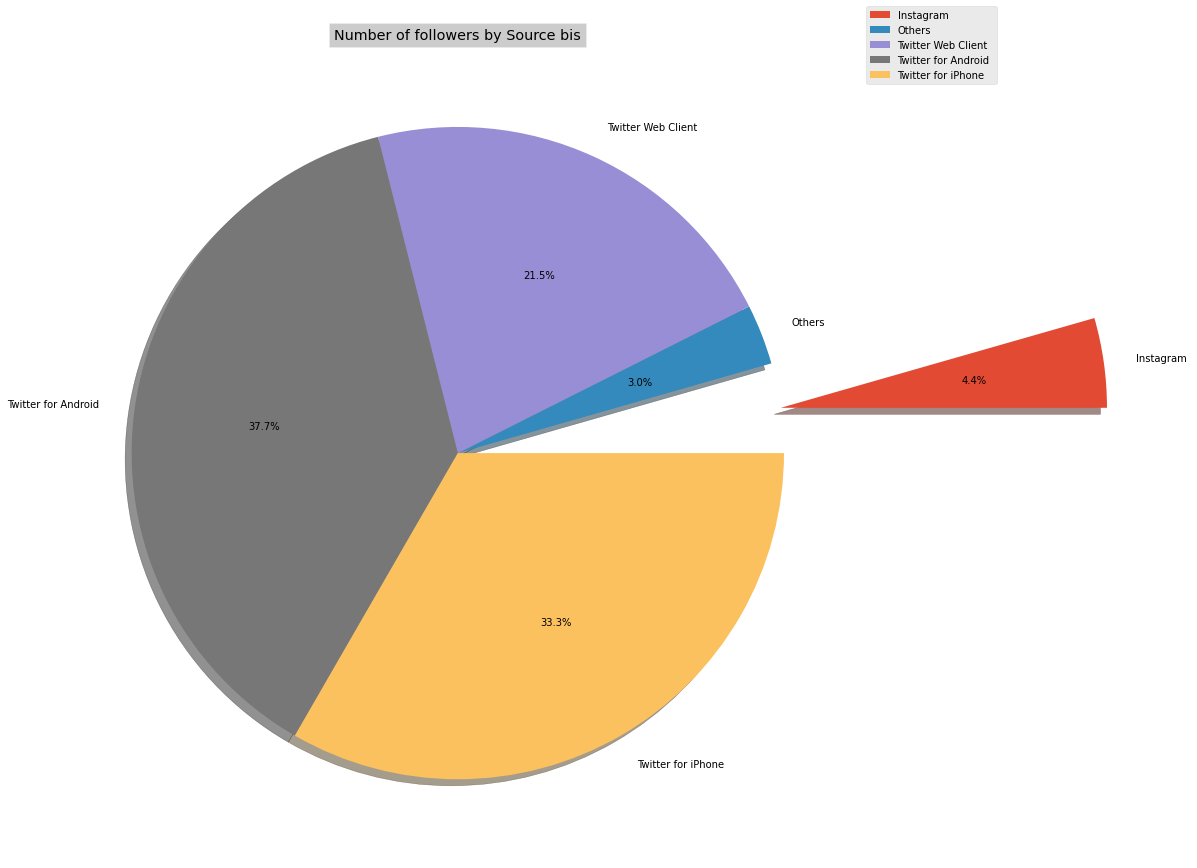

In [ ]:
tweets['source_new2'] = ''

for i in range(len(tweets['source_new'])):
    if tweets['source_new'][i] not in ['Twitter for Android ','Instagram ','Twitter Web Client ','Twitter for iPhone ']:
        tweets['source_new2'][i] = 'Others'
    else:
        tweets['source_new2'][i] = tweets['source_new'][i] 

tweets_by_type2 = tweets.groupby(['source_new2'])['followers_count'].sum()

tweets_by_type2.rename("",inplace=True)
explode = (1, 0, 0, 0, 0)
tweets_by_type2.transpose().plot(kind='pie',figsize=(20, 15),autopct='%1.1f%%',shadow=True,explode=explode)
plt.legend(bbox_to_anchor=(1, 1), loc=6, borderaxespad=0.)
plt.title('Number of followers by Source bis', bbox={'facecolor':'0.8', 'pad':5})

In [ ]:
!pip install mpl_toolkits.basemap


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement mpl_toolkits.basemap (from versions: none)
ERROR: No matching distribution found for mpl_toolkits.basemap


In [ ]:
tweets['text_lem'] = [''.join([WordNetLemmatizer().lemmatize(re.sub('[^A-Za-z]', ' ', line)) for line in lists]).strip() for lists in tweets['text']]       
vectorizer = TfidfVectorizer(max_df=0.5,max_features=10000,min_df=10,stop_words='english',use_idf=True)
X = vectorizer.fit_transform(tweets['text_lem'].str.upper())

In [ ]:
import nltk

In [ ]:
sid = SentimentIntensityAnalyzer()
tweets['sentiment_compound_polarity']=tweets.text_lem.apply(lambda x:sid.polarity_scores(x)['compound'])
tweets['sentiment_neutral']=tweets.text_lem.apply(lambda x:sid.polarity_scores(x)['neu'])
tweets['sentiment_negative']=tweets.text_lem.apply(lambda x:sid.polarity_scores(x)['neg'])
tweets['sentiment_pos']=tweets.text_lem.apply(lambda x:sid.polarity_scores(x)['pos'])
tweets['sentiment_type']=''
tweets.loc[tweets.sentiment_compound_polarity>0,'sentiment_type']='POSITIVE'
tweets.loc[tweets.sentiment_compound_polarity==0,'sentiment_type']='NEUTRAL'
tweets.loc[tweets.sentiment_compound_polarity<0,'sentiment_type']='NEGATIVE'

In [ ]:
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

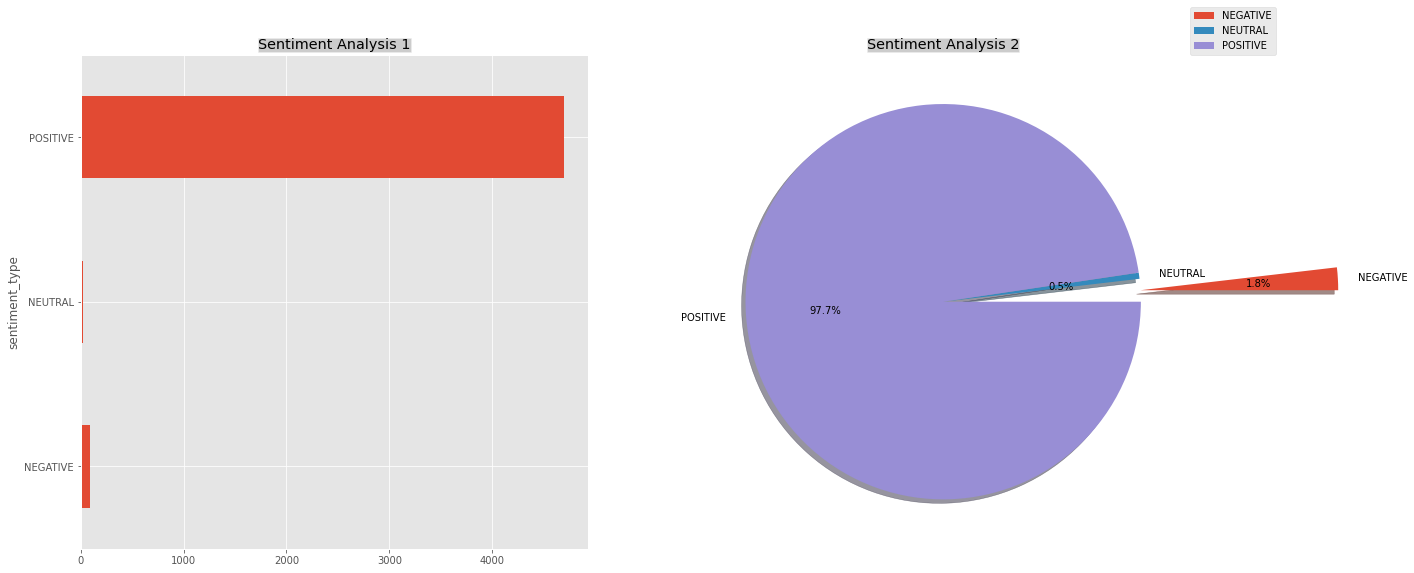

In [ ]:
tweets_sentiment = tweets.groupby(['sentiment_type'])['sentiment_neutral'].count()
tweets_sentiment.rename("",inplace=True)
explode = (1, 0, 0)
plt.subplot(221)
tweets_sentiment.transpose().plot(kind='barh',figsize=(20, 20))
plt.title('Sentiment Analysis 1', bbox={'facecolor':'0.8', 'pad':0})
plt.subplot(222)
tweets_sentiment.plot(kind='pie',figsize=(20, 20),autopct='%1.1f%%',shadow=True,explode=explode)
plt.legend(bbox_to_anchor=(1, 1), loc=3, borderaxespad=0.)
plt.title('Sentiment Analysis 2', bbox={'facecolor':'0.8', 'pad':0})
plt.show()


In [ ]:
tweets[tweets.sentiment_type == 'NEGATIVE'].text.reset_index(drop = True)[0:5]

0    good morning it's time for pastries almond and...
1                                   good morning bitch
2    not a good look when you take a study break to...
3    good morning niece/ it's been awhile- miss you...
4                   good morning from hell that is all
Name: text, dtype: object

In [ ]:
!apt install libproj-dev libgeos-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.9.1-1~focal0).
libgeos-dev set to manually installed.
libproj-dev is already the newest version (7.2.1-1~focal0).
libproj-dev set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.
